In [19]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, roc_curve, auc
import pandas as pd

In [20]:
class AutismDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        for category in os.listdir(root_dir):
            category_dir = os.path.join(root_dir, category)
            if os.path.isdir(category_dir):
                for participant_folder in os.listdir(category_dir):
                    participant_path = os.path.join(category_dir, participant_folder)
                    if os.path.isdir(participant_path):
                        image_paths = []
                        for img_name in os.listdir(participant_path):
                            if img_name.lower().endswith((".jpg", ".jpeg", ".png")):
                                img_full_path = os.path.join(participant_path, img_name)
                                if os.path.isfile(img_full_path):
                                    image_paths.append(img_full_path)
                        if image_paths:
                            self.data.append(image_paths)
                            label = 0 if category == 'TC' else 1
                            self.labels.append(label)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        images = self.data[idx]
        label = self.labels[idx]
        processed_images = [self.transform(Image.open(img).convert("RGB")) for img in images]
        return torch.stack(processed_images), label

In [21]:
def collate_fn(batch):
    images, labels = zip(*batch)
    lengths = [img_seq.size(0) for img_seq in images]

    c, h, w = images[0].size(-3), images[0].size(-2), images[0].size(-1)
    max_seq_len = max(lengths)
    padded_images = torch.zeros(len(images), max_seq_len, c, h, w)

    for i, img_seq in enumerate(images):
        padded_images[i, :len(img_seq)] = img_seq

    return padded_images, lengths, torch.tensor(labels)

In [22]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1] 
        self.resnet = nn.Sequential(*modules)
        for param in self.resnet.parameters():
            param.requires_grad = False  

    def forward(self, x):
        with torch.no_grad():
            features = self.resnet(x)
        features = features.view(features.size(0), -1)
        return features

class SequenceModelWithAttention(nn.Module):
    def __init__(self, feature_dim, hidden_dim, num_layers):
        super(SequenceModelWithAttention, self).__init__()
        self.lstm = nn.LSTM(feature_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.attention_layer = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x, lengths):
        if not isinstance(lengths, torch.Tensor):
            lengths = torch.tensor(lengths, dtype=torch.long, device='cpu')

        packed_input = nn.utils.rnn.pack_padded_sequence(x, lengths.to('cpu'), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        attention_scores = self.attention_layer(output).squeeze(-1)
        attention_weights = F.softmax(attention_scores, dim=1)
        context_vector = torch.sum(output * attention_weights.unsqueeze(-1), dim=1)
        output = self.fc(context_vector)
        return output.view(-1)

    
class AutismPredictionModel(nn.Module):
    def __init__(self, cnn, feature_dim, hidden_dim, num_layers):
        super(AutismPredictionModel, self).__init__()
        self.cnn = cnn
        self.sequence_model = SequenceModelWithAttention(feature_dim, hidden_dim, num_layers)

    def forward(self, image_sequences, lengths):
        batch_size, seq_len, c, h, w = image_sequences.size()
        image_sequences = image_sequences.view(batch_size * seq_len, c, h, w)
        features = self.cnn(image_sequences)
        feature_dim = features.size(1)
        features = features.view(batch_size, seq_len, feature_dim)
        output = self.sequence_model(features, lengths)
        return output


In [23]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dir = "./Dataset_Split4/Augmented_Train"
val_dir = "./Dataset_Split4/Validation"
test_dir = "./Dataset_Split4/Test"

train_dataset = AutismDataset(train_dir, transform)
val_dataset = AutismDataset(val_dir, transform)
test_dataset = AutismDataset(test_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=2, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = CNNFeatureExtractor().to(device)
model = AutismPredictionModel(cnn, feature_dim=2048, hidden_dim=256, num_layers=2).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3, verbose=True, min_lr=1e-7, threshold=0.01)

In [24]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_model = None
best_val_loss = float('inf')
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for images, lengths, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images, lengths)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, lengths, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images, lengths)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model_attention.pth")

    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    scheduler.step(avg_train_loss)

Epoch 1, Training Loss: 0.6760, Training Accuracy: 57.30%, Validation Loss: 0.6189, Validation Accuracy: 75.00%
Epoch 2, Training Loss: 0.6506, Training Accuracy: 66.22%, Validation Loss: 0.5973, Validation Accuracy: 62.50%
Epoch 3, Training Loss: 0.6447, Training Accuracy: 64.05%, Validation Loss: 0.5740, Validation Accuracy: 75.00%
Epoch 4, Training Loss: 0.5863, Training Accuracy: 71.89%, Validation Loss: 0.4643, Validation Accuracy: 75.00%
Epoch 5, Training Loss: 0.5376, Training Accuracy: 77.84%, Validation Loss: 0.6442, Validation Accuracy: 75.00%
Epoch 6, Training Loss: 0.5394, Training Accuracy: 74.59%, Validation Loss: 0.3940, Validation Accuracy: 75.00%
Epoch 7, Training Loss: 0.5317, Training Accuracy: 75.95%, Validation Loss: 0.4041, Validation Accuracy: 75.00%
Epoch 8, Training Loss: 0.4682, Training Accuracy: 77.84%, Validation Loss: 0.3482, Validation Accuracy: 87.50%
Epoch 9, Training Loss: 0.4390, Training Accuracy: 79.46%, Validation Loss: 0.3993, Validation Accuracy:

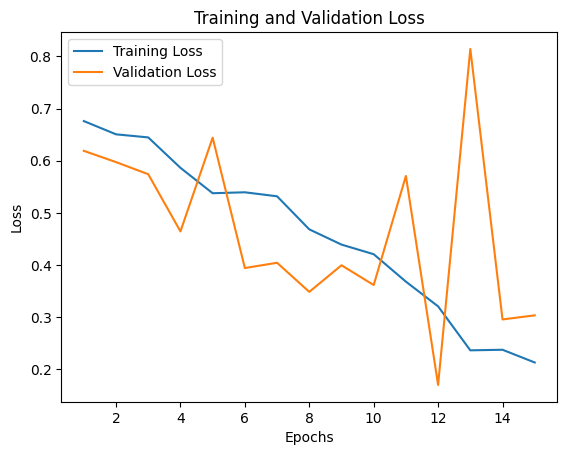

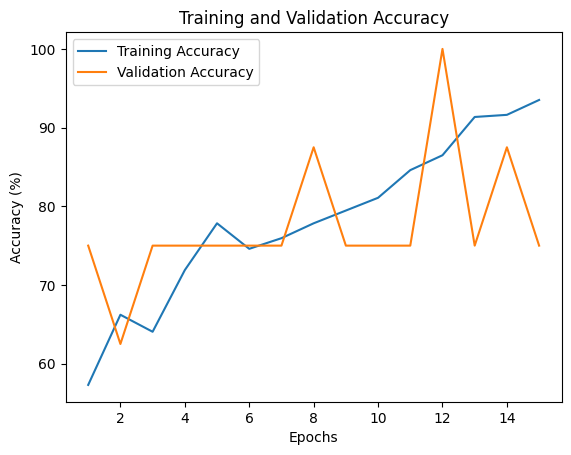

In [25]:
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [26]:
best_model = AutismPredictionModel(cnn, feature_dim=2048, hidden_dim=256, num_layers=2).to(device)
best_model.load_state_dict(torch.load("best_model_attention.pth"))
best_model.eval()
test_loss = 0
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, lengths, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = best_model(images, lengths)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct_test += (preds == labels).sum().item()
        total_test += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test
print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

/tmp/ipykernel_375479/394244500.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_model_attention.pth"))


Test Loss: 0.3075, Test Accuracy: 77.78%


Recall: 1.0000
ROC AUC: 1.0000


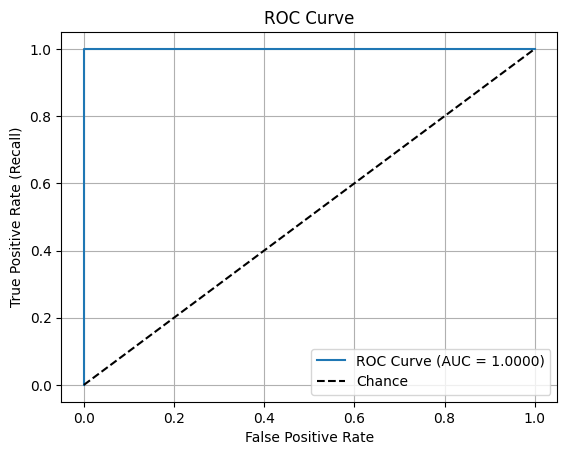

In [27]:
all_labels = []
all_probs = []
all_preds = []

with torch.no_grad():
    for images, lengths, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = best_model(images, lengths)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
all_preds = np.array(all_preds)

recall = recall_score(all_labels, all_preds)
print(f"Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
image_paths = [
    "/home/suhas99/ENPM703/Final/Dataset_Split4/Test/TS/19/TS009_19.png",
    "/home/suhas99/ENPM703/Final/Dataset_Split4/Test/TS/19/TS010_19.png",
    "/home/suhas99/ENPM703/Final/Dataset_Split4/Test/TS/19/TS023_19.png",
    "/home/suhas99/ENPM703/Final/Dataset_Split4/Test/TS/19/TS024_19.png",
    "/home/suhas99/ENPM703/Final/Dataset_Split4/Test/TS/19/TS025_19.png",
    "/home/suhas99/ENPM703/Final/Dataset_Split4/Test/TS/19/TS042_19.png",
    "/home/suhas99/ENPM703/Final/Dataset_Split4/Test/TS/19/TS043_19.png",
    "/home/suhas99/ENPM703/Final/Dataset_Split4/Test/TS/19/TS044_19.png",
    "/home/suhas99/ENPM703/Final/Dataset_Split4/Test/TS/19/TS064_19.png",
    "/home/suhas99/ENPM703/Final/Dataset_Split4/Test/TS/19/TS065_19.png",
    "/home/suhas99/ENPM703/Final/Dataset_Split4/Test/TS/19/TS066_19.png",
    "/home/suhas99/ENPM703/Final/Dataset_Split4/Test/TS/19/TS085_19.png",
    "/home/suhas99/ENPM703/Final/Dataset_Split4/Test/TS/19/TS086_19.png",
    "/home/suhas99/ENPM703/Final/Dataset_Split4/Test/TS/19/TS110_19.png",
    "/home/suhas99/ENPM703/Final/Dataset_Split4/Test/TS/19/TS111_19.png",
    "/home/suhas99/ENPM703/Final/Dataset_Split4/Test/TS/19/TS112_19.png",
]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load and preprocess the images
image_tensors = []
for img_path in image_paths:
    if os.path.isfile(img_path):
        img = Image.open(img_path).convert("RGB")
        img_tensor = transform(img)
        image_tensors.append(img_tensor)
    else:
        print(f"Image not found: {img_path}")

if not image_tensors:
    raise ValueError("No valid images found for prediction.")

image_sequence = torch.stack(image_tensors).unsqueeze(0)

seq_len = len(image_tensors)
lengths = [seq_len]

image_sequence = image_sequence.to(device)

best_model.eval()

with torch.no_grad():
    outputs = best_model(image_sequence, lengths)
    prob = torch.sigmoid(outputs).item()

threshold = 0.5
prediction = 1 if prob > threshold else 0

print(f"Predicted Probability of autism: {prob:.4f}")
print("Predicted Class:", "Autistic" if prediction == 1 else "Not Autistic")

Predicted Probability of autism: 0.9633
Predicted Class: Autistic


In [29]:
test_dir = "./Dataset_Split4/Test"
results = []

for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        for participant_folder in os.listdir(category_dir):
            participant_path = os.path.join(category_dir, participant_folder)
            if os.path.isdir(participant_path):
                image_paths = []
                for img_name in os.listdir(participant_path):
                    if img_name.lower().endswith((".jpg", ".jpeg", ".png")):
                        img_full_path = os.path.join(participant_path, img_name)
                        if os.path.isfile(img_full_path):
                            image_paths.append(img_full_path)
                
                image_tensors = []
                for img_path in image_paths:
                    img = Image.open(img_path).convert("RGB")
                    img_tensor = transform(img)
                    image_tensors.append(img_tensor)
                
                if not image_tensors:
                    continue
                
                image_sequence = torch.stack(image_tensors).unsqueeze(0)  # Add batch dimension
                seq_len = len(image_tensors)
                lengths = [seq_len]

                image_sequence = image_sequence.to(device)

                with torch.no_grad():
                    outputs = best_model(image_sequence, lengths)
                    prob = torch.sigmoid(outputs).item()
                    prediction = 1 if prob > 0.5 else 0
                
                results.append({
                    "Category": category,
                    "Participant": participant_folder,
                    "Prediction": "Autistic" if prediction == 1 else "Not Autistic",
                    "Probability": prob
                })

results_df = pd.DataFrame(results)

# Display or save results
print(results_df)

  Category Participant    Prediction  Probability
0       TC          49      Autistic     0.558230
1       TC          31  Not Autistic     0.113872
2       TC          33  Not Autistic     0.044545
3       TC          58  Not Autistic     0.120972
4       TC          48      Autistic     0.615401
5       TS           9      Autistic     0.821684
6       TS           4      Autistic     0.906898
7       TS          19      Autistic     0.930220
8       TS           8      Autistic     0.768364
